In [7]:
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import seaborn as sns
import xmltodict
import datetime as dt
import pandas as pd

In [8]:
STROKE_STYLE_MAP = {
    '0': 'UnknownStrokeStyle',
    '1': 'MixedStrokeStyle',
    '2': 'FreestyleStrokeStyle',
    '3': 'BackstrokeStrokeStyle',
    '4': 'BreaststrokeStrokeStyle',
    '5': 'ButterflyStrokeStyle',
    '6': 'KickboardStrokeStyle'
}


def parse_stroke_style(value):
    """Converts the stroke style value to its corresponding string."""

    return STROKE_STYLE_MAP.get(value, 'UnknownStrokeStyle')

In [9]:
filepath = '../resources/exportar.xml'
doc = None
with open(filepath, 'r') as f:
    doc = xmltodict.parse(f.read())

In [10]:
def fill_na(record):

    record['WeatherTemperature'] = 0 if not 'WeatherTemperature' in record else record['WeatherTemperature']

    for stroke_style in STROKE_STYLE_MAP.values():

        record[stroke_style] = 0 if not stroke_style in record else record[stroke_style]

    return record

In [11]:
workouts = []
for record in doc['HealthData']['Workout']:

    if record['@workoutActivityType'] == 'HKWorkoutActivityTypeSwimming':

        result_dict = {
            'Duration': record['@duration'],
            'CreationDate': record['@creationDate'],
            'StartDate': record['@startDate'],
            'EndDate': record['@endDate']
        }

        metadata_entry = record['MetadataEntry']
        for entry in metadata_entry:

            key = entry['@key']

            if key == 'HKAverageMETs':

                result_dict['AverageMETs'] = entry['@value'].split(' ')[0]

            if key == 'HKWeatherTemperature':

                result_dict['WeatherTemperature'] = entry['@value'].split(' ')[
                    0]

        workout_statistics = record['WorkoutStatistics']
        for stat in workout_statistics:

            type = stat['@type']

            if type == 'HKQuantityTypeIdentifierDistanceSwimming':

                result_dict['DistanceSwimming'] = stat['@sum']

            if type == 'HKQuantityTypeIdentifierActiveEnergyBurned':

                result_dict['EnergyBurned'] = stat['@sum']

        workout_events = record['WorkoutEvent']
        for event in workout_events:

            type = event['@type']
            if type == 'HKWorkoutEventTypeLap':

                metadata_entry = event['MetadataEntry']
                stroke_style = parse_stroke_style(
                    metadata_entry['@value'])
                result_dict[stroke_style] = result_dict.get(
                    stroke_style, 0) + 1

        result_dict = fill_na(result_dict)
        workouts.append(result_dict)

In [12]:
df = pd.DataFrame(workouts)

In [13]:
df.tail()

,Duration,CreationDate,StartDate,EndDate,AverageMETs,WeatherTemperature,DistanceSwimming,EnergyBurned,FreestyleStrokeStyle,BreaststrokeStrokeStyle,BackstrokeStrokeStyle,ButterflyStrokeStyle,UnknownStrokeStyle,MixedStrokeStyle,KickboardStrokeStyle
21,43.64309015075366,2020-12-12 14:46:00 -0300,2020-12-12 14:02:20 -0300,2020-12-12 14:45:58 -0300,7.31296,82,1650,292.068,36,4,14,12,0,0,0
22,46.60624763170878,2020-12-16 09:49:01 -0300,2020-12-16 09:02:24 -0300,2020-12-16 09:49:00 -0300,7.35324,0,1875,313.597,47,1,12,13,0,2,0
23,44.53501873413722,2020-12-17 16:02:22 -0300,2020-12-17 15:17:49 -0300,2020-12-17 16:02:21 -0300,7.87204,85,2125,325.529,77,3,3,2,0,0,0
24,43.09363808234533,2020-12-18 18:45:45 -0300,2020-12-18 18:02:38 -0300,2020-12-18 18:45:44 -0300,8.25582,77,2100,338.922,49,10,8,17,0,0,0
25,43.83639253377915,2020-12-22 16:01:11 -0300,2020-12-22 15:17:20 -0300,2020-12-22 16:01:10 -0300,7.60109,77,2000,315.915,60,17,2,1,0,0,0


In [14]:
df.dtypes

Duration                   object
CreationDate               object
StartDate                  object
EndDate                    object
AverageMETs                object
WeatherTemperature         object
DistanceSwimming           object
EnergyBurned               object
FreestyleStrokeStyle        int64
BreaststrokeStrokeStyle     int64
BackstrokeStrokeStyle       int64
ButterflyStrokeStyle        int64
UnknownStrokeStyle          int64
MixedStrokeStyle            int64
KickboardStrokeStyle        int64
dtype: object

In [15]:
for col in ['CreationDate', 'StartDate', 'EndDate']:
    df[col] = pd.to_datetime(df[col])

In [16]:
for col in ['Duration', 'AverageMETs', 'WeatherTemperature', 'DistanceSwimming', 'EnergyBurned']:
    df[col] = pd.to_numeric(df[col])

In [17]:
df.dtypes

Duration                                     float64
CreationDate               datetime64[ns, UTC-03:00]
StartDate                  datetime64[ns, UTC-03:00]
EndDate                    datetime64[ns, UTC-03:00]
AverageMETs                                  float64
WeatherTemperature                             int64
DistanceSwimming                               int64
EnergyBurned                                 float64
FreestyleStrokeStyle                           int64
BreaststrokeStrokeStyle                        int64
BackstrokeStrokeStyle                          int64
ButterflyStrokeStyle                           int64
UnknownStrokeStyle                             int64
MixedStrokeStyle                               int64
KickboardStrokeStyle                           int64
dtype: object

In [18]:
df.describe()

,Duration,AverageMETs,WeatherTemperature,DistanceSwimming,EnergyBurned,FreestyleStrokeStyle,BreaststrokeStrokeStyle,BackstrokeStrokeStyle,ButterflyStrokeStyle,UnknownStrokeStyle,MixedStrokeStyle,KickboardStrokeStyle
count,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.0,26.000000,26.0
mean,43.244590,7.534890,61.307692,1797.115385,300.802346,46.269231,6.500000,10.076923,8.000000,0.0,1.038462,0.0
std,2.047749,0.501799,35.057403,198.661386,23.718510,13.119627,5.194228,5.684527,5.628499,0.0,1.310901,0.0
min,38.146259,6.088150,0.000000,1425.000000,234.891000,15.000000,0.000000,1.000000,1.000000,0.0,0.000000,0.0
25%,42.755281,7.290705,65.250000,1650.000000,288.450750,37.500000,3.000000,6.250000,4.000000,0.0,0.000000,0.0
50%,43.610152,7.551355,77.000000,1787.500000,298.257500,48.000000,5.000000,9.500000,6.000000,0.0,0.500000,0.0
75%,44.436556,7.886057,84.500000,1900.000000,312.606750,55.250000,9.500000,13.750000,11.750000,0.0,2.000000,0.0
max,46.606248,8.352810,99.000000,2225.000000,353.056000,77.000000,21.000000,24.000000,19.000000,0.0,4.000000,0.0


In [19]:
df.isna().sum()

Duration                   0
CreationDate               0
StartDate                  0
EndDate                    0
AverageMETs                0
WeatherTemperature         0
DistanceSwimming           0
EnergyBurned               0
FreestyleStrokeStyle       0
BreaststrokeStrokeStyle    0
BackstrokeStrokeStyle      0
ButterflyStrokeStyle       0
UnknownStrokeStyle         0
MixedStrokeStyle           0
KickboardStrokeStyle       0
dtype: int64

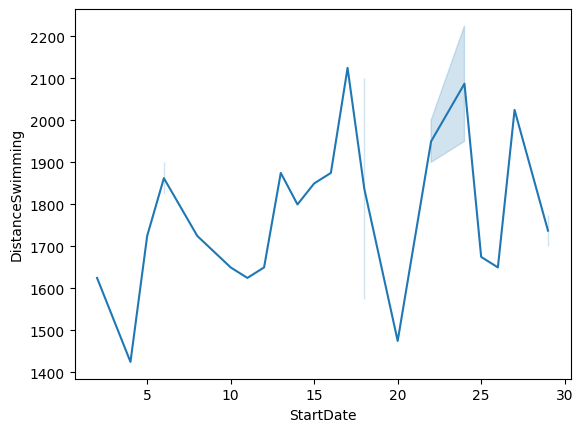

In [20]:
# DistanceSwimming in meters per month
sns.lineplot(x=df['StartDate'].dt.day, y=df['DistanceSwimming'])
plt.show()

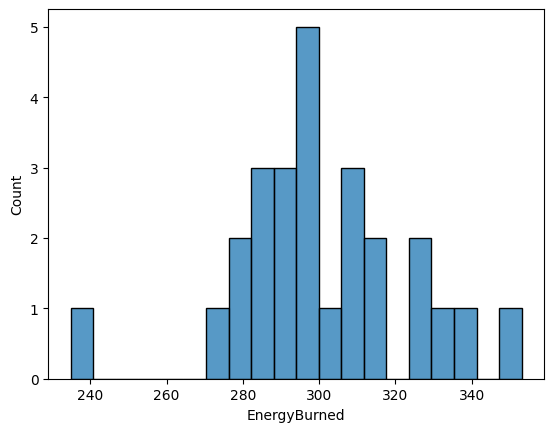

In [21]:
# calories burned per day
sns.histplot(x=df['EnergyBurned'], bins=20)
plt.show()

In [22]:
# total distance, total time, calories mean, weather mean
total_distance = df['DistanceSwimming'].sum()
total_time = df['Duration'].sum()
total_calories = df['EnergyBurned'].sum()
weather_mean = df['WeatherTemperature'].mean()
# convert from degree/F to degree
weather_mean_degrees = (weather_mean - 32) * 5/9

print(f"Total distance: {total_distance} meters")
print(f"Total time: {total_time} minutes")
print(f"Total Calories: {total_calories} calories")
print(f"Weather mean: {weather_mean_degrees} degrees")

Total distance: 46725 meters
Total time: 1124.359333739678 minutes
Total Calories: 7820.861 calories
Weather mean: 16.282051282051285 degrees
